In [122]:
from process.model import MyBiLSTMCRF
from process.preprocess import Preprocess
from gensim.models import Word2Vec
import pandas as pd
import numpy as np

In [83]:
# 标签转编号
tag2id = {'o': 0,
          'B_ns': 1,
          'B_nr': 2,
          'B_nt': 3,
          'I_nt': 4,
          'I_nr': 5,
          'I_ns': 6,
          }
seq_len = 20

train = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/train/train.txt'
test = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/test/test.txt'

train_word_tag = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/train/train_word_tag.txt'
test_word_tag = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/test/test_word_tag.txt'

train_sentences_path = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/train/train_sentences.txt'
train_label_path = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/train/train_labels.txt'
test_sentences_path = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/test/test_sentences.txt'
test_label_path = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/test/test_labels.txt'

train_word_vocabulary = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/train/train_word_vocabulary.txt'
train_char_vocabulary = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/train/train_char_vocabulary.txt'
test_word_vocabulary = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/test/test_word_vocabulary.txt'
test_char_vocabulary = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/test/test_char_vocabulary.txt'

test_sentences_filter_path = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/test/test_sentences_filter.txt'
test_labels_filter_path = '/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/data/MSRA/test/test_labels_filter.txt'


In [84]:
word2vecModel = Word2Vec.load('/Users/liuhy/workspace/NLP/code/MachineLearning/code/Bi-LSTM+CRF/models/word2vec.model')

pp = Preprocess()

In [85]:
num_chars, word_embeddings, char_number_dict, word_number_dict = pp.get_paras(train_char_vocabulary,
                                                                                train_word_vocabulary,
                                                                                test_word_vocabulary,
                                                                                word2vecModel)



In [86]:
train_sentences_chars_vec, train_sentences_words_vec, train_sentences_labels = pp.get_model_seq(char_number_dict,
                                                                                      word_number_dict,
                                                                                      train_sentences_path,
                                                                                      train_label_path,
                                                                                      seq_len)

In [87]:
test_sentences_chars_vec, test_sentences_words_vec, test_sentences_labels = pp.get_model_seq(char_number_dict,
                                                                                      word_number_dict,
                                                                                      test_sentences_filter_path,
                                                                                      test_labels_filter_path,
                                                                                      seq_len)

In [91]:
char_number_dict['<pad>'] = 0

In [239]:
num_chars,len(word_embeddings),len(word_number_dict),len(char_number_dict)

(4547, 63186, 63186, 4548)

In [211]:
X_1 = np.array(train_sentences_chars_vec)
X_2 = np.array(train_sentences_words_vec)
y = np.array(train_sentences_labels)

In [212]:
X_1.shape,X_2.shape,y.shape,type(X_1[1][1])

((98650, 20), (98650, 20), (98650, 20), numpy.int64)

In [164]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras import Model
from tensorflow_addons.text import CRFModelWrapper
import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [351]:
def buildModel():
    # (batch,20)
    input_1 = layers.Input(shape=(20,), name='chars')
    input_2 = layers.Input(shape=(20,), name='words')
    
    #(batch,20,40)  补充：计算input_dim时加一是为了将pad的token添加到词表中
    embed_1 = layers.Embedding(input_dim=(num_chars + 1), output_dim=40, name='embed_1')(input_1)
    embed_2 = layers.Embedding(input_dim=(len(word_number_dict) + 1), output_dim=40, name='embed_2')(input_2)
    
    #(batch,20,40)
    concate = layers.Concatenate(name='concate')([embed_1, embed_2])
    
    #(batch,20,7)  数据量太小为了让模型简单点所以删除了一个lstm层
#     x = layers.Bidirectional(layers.LSTM(7, return_sequences=True, activation='tanh'),merge_mode='sum', name='lstm_1')(concate)      
    output = layers.Bidirectional(layers.LSTM(7, return_sequences=True, activation='softmax'),merge_mode='sum', name='lstm_2')(concate)     
    
    base_model = Model(inputs=[input_1,input_2], outputs=output, name='base_model')
    
    crf = CRFModelWrapper(base_model, units=7 , name='crf_model')
    
    return base_model, crf

In [298]:
base_model, crf_model = buildModel()

In [299]:
crf_model.compile(optimizer=tf.keras.optimizers.Adam(5e-5))

In [300]:
BATCH_SIZE = 64

In [301]:
crf_model.build([(BATCH_SIZE,20,),(BATCH_SIZE,20,)])

In [352]:
??crf_model.build

In [302]:
base_model.summary()

Model: "base_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
chars (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
words (InputLayer)              [(None, 20)]         0                                            
__________________________________________________________________________________________________
embed_1 (Embedding)             (None, 20, 40)       181920      chars[0][0]                      
__________________________________________________________________________________________________
embed_2 (Embedding)             (None, 20, 40)       2527480     words[0][0]                      
_________________________________________________________________________________________

In [303]:
crf_model.summary()

Model: "crf_model_wrapper_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
crf_model (CRF)              multiple                  119       
_________________________________________________________________
base_model (Functional)      (None, 20, 7)             2714328   
Total params: 2,714,447
Trainable params: 2,714,447
Non-trainable params: 0
_________________________________________________________________


In [304]:
epochs=33
history = crf_model.fit({'chars':X_1, 'words':X_2}, y, validation_split=0.1,batch_size=BATCH_SIZE,epochs=epochs)       

Epoch 1/50
1388/1388 [==============================] - 38s 25ms/step - loss: 27.7361 - crf_loss: 27.7361 - val_loss: 20.4528 - val_crf_loss: 20.4528
Epoch 2/50
1388/1388 [==============================] - 33s 24ms/step - loss: 14.3400 - crf_loss: 14.3400 - val_loss: 10.1728 - val_crf_loss: 10.1728
Epoch 3/50
1388/1388 [==============================] - 35s 25ms/step - loss: 8.6340 - crf_loss: 8.6340 - val_loss: 7.0347 - val_crf_loss: 7.0347
Epoch 4/50
1388/1388 [==============================] - 34s 24ms/step - loss: 6.4976 - crf_loss: 6.4976 - val_loss: 5.5687 - val_crf_loss: 5.5687
Epoch 5/50
1388/1388 [==============================] - 35s 25ms/step - loss: 5.3126 - crf_loss: 5.3126 - val_loss: 4.7441 - val_crf_loss: 4.7441
Epoch 6/50
1388/1388 [==============================] - 34s 25ms/step - loss: 4.5249 - crf_loss: 4.5249 - val_loss: 4.2128 - val_crf_loss: 4.2128
Epoch 7/50
1388/1388 [==============================] - 35s 25ms/step - loss: 3.9403 - crf_loss: 3.9403 - val_loss: 

### CRFModelWrapper的模型输出结果history中记录了所有epochs的loss和验证集的loss

In [313]:
import matplotlib.pyplot as plot
import seaborn as sns
import pandas as pd

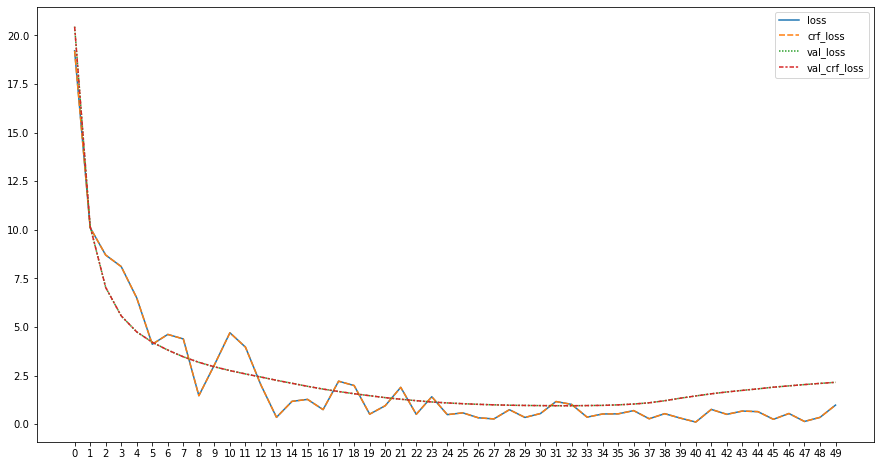

In [312]:
data = pd.DataFrame(history.history)
fig, ax = plot.subplots(figsize=(15,8))
sns.lineplot(data=data, ax=ax)
ax.set_xticks(range(epochs))
plot.show()

In [257]:
test_X_1 = np.array(test_sentences_chars_vec, dtype='int32')
test_X_2 = np.array(test_sentences_words_vec, dtype='int32')
y_true = np.array(test_sentences_labels, dtype='int32')

In [259]:
test_X_1.shape, test_X_2.shape, y_true.shape

((172, 20), (172, 20), (172, 20))

In [261]:
y_pre = crf_model.predict([test_X_1,test_X_2])

In [268]:
import codecs

In [276]:
test_sentences_reader = codecs.open(test_sentences_filter_path, 'r', 'utf-8')
test_sentences = []
for line in test_sentences_reader.readlines():
    test_sentences.append(line.strip('\n'))

test_sentences_reader.close

len(test_sentences)

172

In [281]:
id2tag = dict(zip(tag2id.values(), tag2id.keys()))
id2tag

{0: 'o', 1: 'B_ns', 2: 'B_nr', 3: 'B_nt', 4: 'I_nt', 5: 'I_nr', 6: 'I_ns'}

In [314]:
count = 0
for i in range(len(y_true)):
    if (y_true[i] != y_pre[i]).any():
        count += 1
        print(i)
        print(test_sentences[i])
        print([id2tag[key] for key in y_true[i]])
        print([id2tag[key] for key in y_pre[i]])
        print('=====================================')
print(count)

5
在芬兰故都土尔库举行的和平圣诞庆祝仪式
['o', 'B_ns', 'I_ns', 'o', 'o', 'B_ns', 'I_ns', 'I_ns', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
['o', 'I_nt', 'I_nt', 'I_nt', 'I_nt', 'I_nt', 'I_nt', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
7
大多数芬兰人在１２点钟会准时打开收音机收听仪式实况
['o', 'o', 'o', 'B_ns', 'I_ns', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
9
许多芬兰人觉得祭奠故人是圣诞节最严肃的事情
['o', 'o', 'B_ns', 'I_ns', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
16
而在首都赫尔辛基
['o', 'o', 'o', 'o', 'B_ns', 'I_ns', 'I_ns', 'I_ns', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
['o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o']
19
芬兰的家庭在圣诞夜时总有圣诞老人造访
['B_ns', 'I_ns', 'o', 'o', 

In [291]:
type(y_true),type(y_pre)

(numpy.ndarray, numpy.ndarray)

In [315]:
from sklearn.metrics import classification_report, confusion_matrix

In [330]:
y_true_flat = y_true.flatten()
y_pre_flat = y_pre.flatten()
print(classification_report(y_true_flat, y_pre_flat, target_names=tag2id.keys(), labels=list(tag2id.values())))

              precision    recall  f1-score   support

           o       0.98      1.00      0.99      3356
        B_ns       0.00      0.00      0.00        27
        B_nr       0.00      0.00      0.00         6
        B_nt       0.00      0.00      0.00         1
        I_nt       0.00      0.00      0.00        10
        I_nr       0.00      0.00      0.00        15
        I_ns       0.00      0.00      0.00        25

    accuracy                           0.97      3440
   macro avg       0.14      0.14      0.14      3440
weighted avg       0.95      0.97      0.96      3440



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

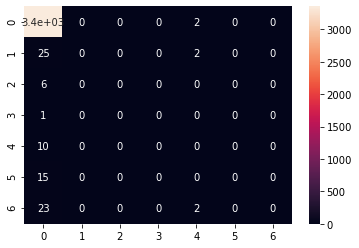

In [337]:
data_confusion_matrix = confusion_matrix(y_true=y_true_flat, y_pred=y_pre_flat, labels=list(tag2id.values()))

sns.heatmap(data=data_confusion_matrix, annot=True)

### 结果不是很理想，数据量太小模型较复杂 过拟合严重。

In [340]:
crf_model.save('./models/crf_model.model')

INFO:tensorflow:Assets written to: ./models/crf_model.model/assets


INFO:tensorflow:Assets written to: ./models/crf_model.model/assets


### 模型保存和重新加载

In [343]:
mymodel = tf.keras.models.load_model('./models/crf_model.model')

In [344]:
mymodel.summary()

Model: "crf_model_wrapper_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
crf_model (CRF)              multiple                  119       
_________________________________________________________________
base_model (Functional)      (None, 20, 7)             2714328   
Total params: 2,714,447
Trainable params: 2,714,447
Non-trainable params: 0
_________________________________________________________________


In [347]:
y111 = mymodel.predict([test_X_1,test_X_2])

In [350]:
y111.shape

(172, 20)